# Starting from today, we will move on to artificial neural network model

### Using COVID-19 radiomics data

## Import the library

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.feature_selection import RFECV

from sklearn.neural_network import MLPClassifier

## Load clinical data

In [2]:
clinical_data = pd.read_excel('L11.1_clinical_data.xlsx', header = 0, index_col = 0)
clinical_data.head(10)

,Class,CT,WBC,L_number,N_number,Platelet
Patient ID,,,,,,
1,Positive,12.89,5310.0,960.0,3660.0,131000.0
2,Positive,26.76,2800.0,1030.0,1170.0,89000.0
3,Positive,26.39,4170.0,1030.0,2800.0,138000.0
5,Positive,30.06,5460.0,1810.0,3160.0,231000.0
6,Positive,26.28,8220.0,1390.0,6390.0,208000.0
7,Positive,25.42,5690.0,1450.0,3950.0,189000.0
8,Positive,26.86,3460.0,920.0,2190.0,118000.0
9,Positive,21.01,7280.0,1820.0,4930.0,201000.0
10,Positive,NaN,5270.0,1430.0,3440.0,249000.0


## Create label data for COVID-19 classification
Use **DataFrame.astype(int)** to convert True/False to 1/0

In [3]:
covid_label = (clinical_data['Class'] == 'Positive').astype(int)
covid_label.head()

Patient ID
1    1
2    1
3    1
5    1
6    1
Name: Class, dtype: int32

## Load radiomics data for 6 lung regions
We create a dictionary to store the individual lung region's data

**Note**:
1. We know in advance that there is no missing data here
2. Since all csv files have the same column headers, we use **DataFrame.add_suffix()** to add suffix to the columns

In [4]:
lung_regions = ['lower_left', 'mid_left', 'upper_left', 'lower_right', 'mid_right', 'upper_right']
data_raw = {}

for r in lung_regions:
    data_raw[r] = pd.read_csv('L11.1_' + r + '_lung_radiomics.csv', header = 0, index_col = 0).add_suffix('_' + r)
    
data_raw['lower_left'].head()

,original_shape2D_Elongation_lower_left,original_shape2D_MajorAxisLength_lower_left,original_shape2D_MaximumDiameter_lower_left,original_shape2D_MeshSurface_lower_left,original_shape2D_MinorAxisLength_lower_left,original_shape2D_Perimeter_lower_left,original_shape2D_PerimeterSurfaceRatio_lower_left,original_shape2D_PixelSurface_lower_left,original_shape2D_Sphericity_lower_left,original_firstorder_10Percentile_lower_left,...,wavelet-LL_gldm_LargeDependenceLowGrayLevelEmphasis_lower_left,wavelet-LL_gldm_LowGrayLevelEmphasis_lower_left,wavelet-LL_gldm_SmallDependenceEmphasis_lower_left,wavelet-LL_gldm_SmallDependenceHighGrayLevelEmphasis_lower_left,wavelet-LL_gldm_SmallDependenceLowGrayLevelEmphasis_lower_left,wavelet-LL_ngtdm_Busyness_lower_left,wavelet-LL_ngtdm_Coarseness_lower_left,wavelet-LL_ngtdm_Complexity_lower_left,wavelet-LL_ngtdm_Contrast_lower_left,wavelet-LL_ngtdm_Strength_lower_left
ID,,,,,,,,,,,,,,,,,,,,,
1,0.764978,157.631361,184.370493,14088.86354,120.584500,529.277862,0.037567,14088.87320,0.794985,-0.750019,...,0.013489,0.000611,0.140209,726.296035,0.000078,0.363703,0.000273,2710.866852,0.036529,1.871671
2,0.688672,177.563823,208.502456,16217.43879,122.283254,576.017986,0.035518,16217.44845,0.783718,-0.935750,...,0.008966,0.000599,0.177496,1112.631326,0.000107,0.474238,0.000192,3369.767187,0.054712,1.507828
3,0.670128,156.781103,180.350023,12194.72930,105.063410,507.562532,0.041621,12194.73897,0.771261,-0.483610,...,0.006129,0.000372,0.145532,891.833985,0.000059,0.344083,0.000271,3115.266473,0.031005,1.890196
5,0.698556,164.394142,189.408043,14042.43518,114.838515,535.634745,0.038144,14042.44484,0.784255,-1.005184,...,0.014026,0.000706,0.125656,678.216878,0.000092,0.308843,0.000377,2379.703718,0.051951,2.367572
6,0.680535,145.326831,171.457782,10557.31320,98.900031,468.895981,0.044414,10557.32286,0.776793,0.326019,...,0.001986,0.000203,0.255015,2080.056579,0.000057,0.385421,0.000183,5216.631799,0.035996,1.805214


## Merge data from 6 lung regions into a single DataFrame

In [5]:
data_raw_merged = pd.concat([data_raw[r] for r in lung_regions], axis = 1)

print('merged data dimension:', data_raw_merged.shape)

merged data dimension: (562, 2784)


## Standardize each feature

In [6]:
scaler = StandardScaler()
data_std = data_raw_merged.copy()
data_std.loc[:, :] = scaler.fit_transform(data_raw_merged)
data_std.head(10)

,original_shape2D_Elongation_lower_left,original_shape2D_MajorAxisLength_lower_left,original_shape2D_MaximumDiameter_lower_left,original_shape2D_MeshSurface_lower_left,original_shape2D_MinorAxisLength_lower_left,original_shape2D_Perimeter_lower_left,original_shape2D_PerimeterSurfaceRatio_lower_left,original_shape2D_PixelSurface_lower_left,original_shape2D_Sphericity_lower_left,original_firstorder_10Percentile_lower_left,...,wavelet-LL_gldm_LargeDependenceLowGrayLevelEmphasis_upper_right,wavelet-LL_gldm_LowGrayLevelEmphasis_upper_right,wavelet-LL_gldm_SmallDependenceEmphasis_upper_right,wavelet-LL_gldm_SmallDependenceHighGrayLevelEmphasis_upper_right,wavelet-LL_gldm_SmallDependenceLowGrayLevelEmphasis_upper_right,wavelet-LL_ngtdm_Busyness_upper_right,wavelet-LL_ngtdm_Coarseness_upper_right,wavelet-LL_ngtdm_Complexity_upper_right,wavelet-LL_ngtdm_Contrast_upper_right,wavelet-LL_ngtdm_Strength_upper_right
ID,,,,,,,,,,,,,,,,,,,,,
1,0.580571,-0.175483,-0.161272,-0.160440,-0.094202,-0.153863,-0.094743,-0.160440,0.261909,-0.676179,...,3.714307,2.694273,-1.878939,-1.640014,0.263514,-0.062781,0.343192,-1.072917,-1.211807,0.723416
2,-0.607040,0.005840,0.025443,-0.122377,-0.072337,-0.028912,-0.385133,-0.122377,-0.168787,-1.112640,...,-0.079439,-0.563723,-0.858617,-0.130931,-1.233388,-0.323352,-0.214935,-0.868857,-0.480316,-0.362189
3,-0.895658,-0.183217,-0.192379,-0.194310,-0.293971,-0.211915,0.479943,-0.194310,-0.644976,-0.050124,...,-0.361562,-0.384719,-0.044352,0.326665,-0.309037,-0.849795,0.635321,-0.660040,0.230341,0.318373
5,-0.453209,-0.113963,-0.122295,-0.161270,-0.168157,-0.136869,-0.012971,-0.161270,-0.148266,-1.275809,...,-0.642569,-1.054887,-0.890468,0.140379,-1.539240,-0.372136,0.105147,-1.262728,0.128301,-0.243544
6,-0.733681,-0.287415,-0.261180,-0.223589,-0.373298,-0.315283,0.875817,-0.223589,-0.433528,1.852484,...,-0.458439,-0.483912,1.059189,1.176996,-0.135305,-1.368084,0.956230,-0.154974,0.157613,0.629395
7,0.338809,-0.336528,-0.294432,-0.219615,-0.296484,-0.322171,0.712131,-0.219615,0.043186,0.919660,...,0.281540,0.084627,-1.011539,-0.877875,-0.613486,-0.115396,0.305255,-1.128806,-0.812246,0.488213
8,0.829199,-0.103743,-0.054805,-0.125433,0.017477,-0.073985,-0.480448,-0.125433,0.571509,-1.465474,...,-0.633595,-0.802853,0.014250,0.201507,-0.734734,0.725349,-0.733097,-0.053426,0.171548,-0.827008
9,-1.037116,-0.141331,-0.165821,-0.185371,-0.273135,-0.205655,0.273775,-0.185371,-0.184924,-0.701295,...,-0.605595,-0.821225,-0.398503,0.620258,-0.995881,-0.330512,-0.457721,-0.194501,1.018285,-0.704275
10,-0.151711,-0.280277,-0.248649,-0.208843,-0.296106,-0.295737,0.510735,-0.208843,0.231022,1.943105,...,-0.593948,-0.489197,1.472881,0.783751,0.224115,-0.728545,0.030968,0.868117,-0.029937,-0.008008


## Split data into 75-25 train-test
Use **train_test_split()** with stratification

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data_std, covid_label, test_size = 0.25, stratify = covid_label, \
                                                    shuffle = True, random_state = 3011979)

## Let's try the default MLP model
Note that scikit-learn's MLP implementation automatically sets input and output layer sizes and handle the validation splitting

Default model has **one hidden layer with 100 neurons**

In [8]:
base_mlp = MLPClassifier(hidden_layer_sizes = 100, activation = 'relu', solver = 'adam', \
                         alpha = 0.0001, batch_size = 'auto', learning_rate = 'constant', \
                         learning_rate_init = 0.001, max_iter = 200, random_state = 3011979, \
                         verbose = True, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

In [9]:
base_mlp.fit(X_train, y_train)

Iteration 1, loss = 0.84733133
Validation score: 0.708661
Iteration 2, loss = 0.63556530
Validation score: 0.629921
Iteration 3, loss = 0.50990618
Validation score: 0.645669
Iteration 4, loss = 0.34316660
Validation score: 0.677165
Iteration 5, loss = 0.24242779
Validation score: 0.677165
Iteration 6, loss = 0.19424903
Validation score: 0.692913
Iteration 7, loss = 0.15112597


C:\Users\Sira\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sira\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sira\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sira\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sira\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sira\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature name

Validation score: 0.748031
Iteration 8, loss = 0.12624429
Validation score: 0.732283
Iteration 9, loss = 0.09839938
Validation score: 0.692913
Iteration 10, loss = 0.09403430
Validation score: 0.685039
Iteration 11, loss = 0.07596795
Validation score: 0.716535
Iteration 12, loss = 0.05898685
Validation score: 0.716535
Iteration 13, loss = 0.05248489


C:\Users\Sira\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sira\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sira\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sira\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sira\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sira\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature name

Validation score: 0.724409
Iteration 14, loss = 0.04407115
Validation score: 0.677165
Iteration 15, loss = 0.03825785
Validation score: 0.685039
Iteration 16, loss = 0.03400148
Validation score: 0.685039
Iteration 17, loss = 0.02985454
Validation score: 0.685039
Iteration 18, loss = 0.02534555
Validation score: 0.692913
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


C:\Users\Sira\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sira\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sira\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sira\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


MLPClassifier(early_stopping=True, hidden_layer_sizes=100, random_state=3011979,
              validation_fraction=0.3, verbose=True)

## Explore the results of MLP model fitting
### First are model coefficients: **MLPClassifier.coefs_**

In [10]:
for w in base_mlp.coefs_:
    print(w.shape)

(2784, 100)
(100, 1)


### Next are model intercepts: **MLPClassifier.intercepts_**

In [11]:
for w in base_mlp.intercepts_:
    print(w.shape)

(100,)
(1,)


### And the validation loss over time
Default loss function for classification is the cross-entropy: $-\sum_{i=1}^{N}\sum_{c=1}^{M}y_{i,c}\log(p_{i,c})$
* $y_{i,c}=1$ if the label for the $i$-th data point is $c$
* $p_{i,c}$ is the predicted probability for class $c$ for the $i$-th data point 

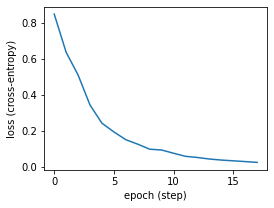

In [12]:
plt.figure(figsize = (4, 3))
plt.plot(range(len(base_mlp.loss_curve_)), base_mlp.loss_curve_)
plt.xlabel('epoch (step)')
plt.ylabel('loss (cross-entropy)')
plt.show()

## Let's explore the impact of batch size
Default batch size = **min(200, n_samples)** = 200 here

### Reduce batch size to let the gradient updates be more variable

In [13]:
batch16_mlp = MLPClassifier(hidden_layer_sizes = 100, activation = 'relu', solver = 'adam', \
                            alpha = 0.0001, batch_size = 16, learning_rate = 'constant', \
                            learning_rate_init = 0.001, max_iter = 200, random_state = 3011979, \
                            verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

batch32_mlp = MLPClassifier(hidden_layer_sizes = 100, activation = 'relu', solver = 'adam', \
                            alpha = 0.0001, batch_size = 32, learning_rate = 'constant', \
                            learning_rate_init = 0.001, max_iter = 200, random_state = 3011979, \
                            verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

batch64_mlp = MLPClassifier(hidden_layer_sizes = 100, activation = 'relu', solver = 'adam', \
                            alpha = 0.0001, batch_size = 64, learning_rate = 'constant', \
                            learning_rate_init = 0.001, max_iter = 200, random_state = 3011979, \
                            verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

In [14]:
batch16_mlp.fit(X_train, y_train)
batch32_mlp.fit(X_train, y_train)
batch64_mlp.fit(X_train, y_train)

MLPClassifier(batch_size=64, early_stopping=True, hidden_layer_sizes=100,
              random_state=3011979, validation_fraction=0.3)

### Compare loss curves

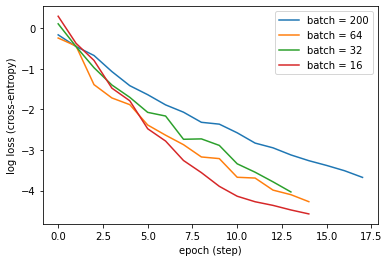

In [15]:
plt.figure(figsize = (6, 4))
plt.plot(range(len(base_mlp.loss_curve_)), np.log(base_mlp.loss_curve_), label = 'batch = 200')
plt.plot(range(len(batch64_mlp.loss_curve_)), np.log(batch64_mlp.loss_curve_), label = 'batch = 64')
plt.plot(range(len(batch32_mlp.loss_curve_)), np.log(batch32_mlp.loss_curve_), label = 'batch = 32')
plt.plot(range(len(batch16_mlp.loss_curve_)), np.log(batch16_mlp.loss_curve_), label = 'batch = 16')
plt.xlabel('epoch (step)')
plt.ylabel('log loss (cross-entropy)')
plt.legend()
plt.show()

In [16]:
print('batch = 200 best val acc:', base_mlp.best_validation_score_)
print('batch = 64 best val acc:', batch64_mlp.best_validation_score_)
print('batch = 32 best val acc:', batch32_mlp.best_validation_score_)
print('batch = 16 best val acc:', batch16_mlp.best_validation_score_)

batch = 200 best val acc: 0.7480314960629921
batch = 64 best val acc: 0.7401574803149606
batch = 32 best val acc: 0.7244094488188977
batch = 16 best val acc: 0.7322834645669292


## Let's try adjusting learning rate and use adaptive learning rate
**adaptive** decreases the learning rate by 5-fold if the loss fails to decrease in two consecutive epochs

Also increase initial learning rate to 0.01 to speed up the early steps

In [17]:
batch64_adaptive_mlp = MLPClassifier(hidden_layer_sizes = 100, activation = 'relu', solver = 'adam', \
                            alpha = 0.0001, batch_size = 64, learning_rate = 'adaptive', \
                            learning_rate_init = 0.01, max_iter = 200, random_state = 3011979, \
                            verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

batch32_adaptive_mlp = MLPClassifier(hidden_layer_sizes = 100, activation = 'relu', solver = 'adam', \
                             alpha = 0.0001, batch_size = 32, learning_rate = 'adaptive', \
                             learning_rate_init = 0.01, max_iter = 200, random_state = 3011979, \
                             verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

batch16_adaptive_mlp = MLPClassifier(hidden_layer_sizes = 100, activation = 'relu', solver = 'adam', \
                             alpha = 0.0001, batch_size = 16, learning_rate = 'adaptive', \
                             learning_rate_init = 0.01, max_iter = 200, random_state = 3011979, \
                             verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

In [18]:
batch16_adaptive_mlp.fit(X_train, y_train)
batch32_adaptive_mlp.fit(X_train, y_train)
batch64_adaptive_mlp.fit(X_train, y_train)

MLPClassifier(batch_size=64, early_stopping=True, hidden_layer_sizes=100,
              learning_rate='adaptive', learning_rate_init=0.01,
              random_state=3011979, validation_fraction=0.3)

### Compare loss curves

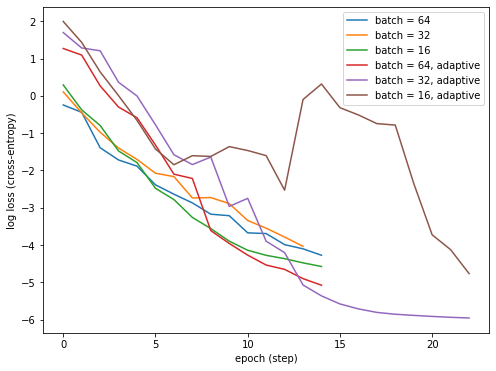

In [19]:
plt.figure(figsize = (8, 6))
plt.plot(range(len(batch64_mlp.loss_curve_)), np.log(batch64_mlp.loss_curve_), label = 'batch = 64')
plt.plot(range(len(batch32_mlp.loss_curve_)), np.log(batch32_mlp.loss_curve_), label = 'batch = 32')
plt.plot(range(len(batch16_mlp.loss_curve_)), np.log(batch16_mlp.loss_curve_), label = 'batch = 16')
plt.plot(range(len(batch64_adaptive_mlp.loss_curve_)), np.log(batch64_adaptive_mlp.loss_curve_), label = 'batch = 64, adaptive')
plt.plot(range(len(batch32_adaptive_mlp.loss_curve_)), np.log(batch32_adaptive_mlp.loss_curve_), label = 'batch = 32, adaptive')
plt.plot(range(len(batch16_adaptive_mlp.loss_curve_)), np.log(batch16_adaptive_mlp.loss_curve_), label = 'batch = 16, adaptive')
plt.xlabel('epoch (step)')
plt.ylabel('log loss (cross-entropy)')
plt.legend()
plt.show()

## Let's try various activation functions
* **identity** will reduce the hidden layer of MLP to linear regression
* **logistic** (or sigmoid) output values in range (0, 1)
* **tanh** output values in range (-1, 1)

In [20]:
print('output activation:', batch32_adaptive_mlp.out_activation_)

output activation: logistic


In [21]:
batch32_adaptive_identity_mlp = MLPClassifier(hidden_layer_sizes = 100, activation = 'identity', solver = 'adam', \
                             alpha = 0.0001, batch_size = 32, learning_rate = 'adaptive', \
                             learning_rate_init = 0.01, max_iter = 200, random_state = 3011979, \
                             verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

batch32_adaptive_logistic_mlp = MLPClassifier(hidden_layer_sizes = 100, activation = 'logistic', solver = 'adam', \
                             alpha = 0.0001, batch_size = 32, learning_rate = 'adaptive', \
                             learning_rate_init = 0.01, max_iter = 200, random_state = 3011979, \
                             verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

batch32_adaptive_tanh_mlp = MLPClassifier(hidden_layer_sizes = 100, activation = 'tanh', solver = 'adam', \
                             alpha = 0.0001, batch_size = 32, learning_rate = 'adaptive', \
                             learning_rate_init = 0.01, max_iter = 200, random_state = 3011979, \
                             verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

In [22]:
batch32_adaptive_identity_mlp.fit(X_train, y_train)
batch32_adaptive_logistic_mlp.fit(X_train, y_train)
batch32_adaptive_tanh_mlp.fit(X_train, y_train)

MLPClassifier(activation='tanh', batch_size=32, early_stopping=True,
              hidden_layer_sizes=100, learning_rate='adaptive',
              learning_rate_init=0.01, random_state=3011979,
              validation_fraction=0.3)

### Compare loss curves

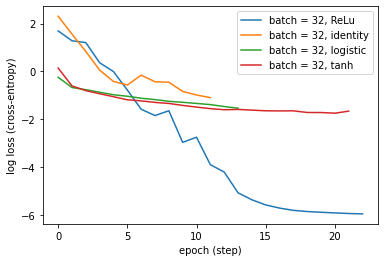

In [23]:
plt.figure(figsize = (6, 4))
plt.plot(range(len(batch32_adaptive_mlp.loss_curve_)), np.log(batch32_adaptive_mlp.loss_curve_), label = 'batch = 32, ReLu')
plt.plot(range(len(batch32_adaptive_identity_mlp.loss_curve_)), np.log(batch32_adaptive_identity_mlp.loss_curve_), label = 'batch = 32, identity')
plt.plot(range(len(batch32_adaptive_logistic_mlp.loss_curve_)), np.log(batch32_adaptive_logistic_mlp.loss_curve_), label = 'batch = 32, logistic')
plt.plot(range(len(batch32_adaptive_tanh_mlp.loss_curve_)), np.log(batch32_adaptive_tanh_mlp.loss_curve_), label = 'batch = 32, tanh')
plt.xlabel('epoch (step)')
plt.ylabel('log loss (cross-entropy)')
plt.legend()
plt.show()

## Let's tune the model complexity

In [24]:
neuron32_mlp = MLPClassifier(hidden_layer_sizes = 32, activation = 'relu', solver = 'adam', \
                              alpha = 0.0001, batch_size = 32, learning_rate = 'adaptive', \
                              learning_rate_init = 0.01, max_iter = 200, random_state = 3011979, \
                              verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

neuron64_mlp = MLPClassifier(hidden_layer_sizes = 64, activation = 'relu', solver = 'adam', \
                              alpha = 0.0001, batch_size = 32, learning_rate = 'adaptive', \
                              learning_rate_init = 0.01, max_iter = 200, random_state = 3011979, \
                              verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

neuron128_mlp = MLPClassifier(hidden_layer_sizes = 128, activation = 'relu', solver = 'adam', \
                              alpha = 0.0001, batch_size = 32, learning_rate = 'adaptive', \
                              learning_rate_init = 0.01, max_iter = 200, random_state = 3011979, \
                              verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

neuron256_mlp = MLPClassifier(hidden_layer_sizes = 256, activation = 'relu', solver = 'adam', \
                              alpha = 0.0001, batch_size = 32, learning_rate = 'adaptive', \
                              learning_rate_init = 0.01, max_iter = 200, random_state = 3011979, \
                              verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

neuron512_mlp = MLPClassifier(hidden_layer_sizes = 512, activation = 'relu', solver = 'adam', \
                              alpha = 0.0001, batch_size = 32, learning_rate = 'adaptive', \
                              learning_rate_init = 0.01, max_iter = 200, random_state = 3011979, \
                              verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

In [25]:
neuron32_mlp.fit(X_train, y_train)
neuron64_mlp.fit(X_train, y_train)
neuron128_mlp.fit(X_train, y_train)
neuron256_mlp.fit(X_train, y_train)
neuron512_mlp.fit(X_train, y_train)

MLPClassifier(batch_size=32, early_stopping=True, hidden_layer_sizes=512,
              learning_rate='adaptive', learning_rate_init=0.01,
              random_state=3011979, validation_fraction=0.3)

### Compare loss curves

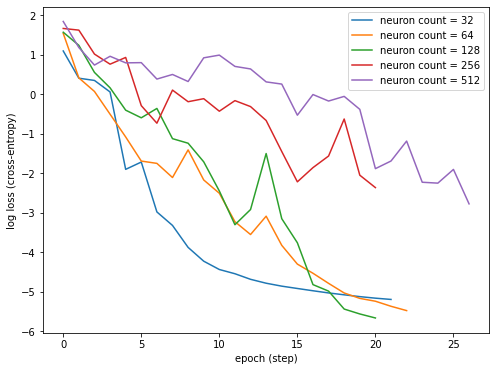

In [26]:
plt.figure(figsize = (8, 6))
plt.plot(range(len(neuron32_mlp.loss_curve_)), np.log(neuron32_mlp.loss_curve_), label = 'neuron count = 32')
plt.plot(range(len(neuron64_mlp.loss_curve_)), np.log(neuron64_mlp.loss_curve_), label = 'neuron count = 64')
plt.plot(range(len(neuron128_mlp.loss_curve_)), np.log(neuron128_mlp.loss_curve_), label = 'neuron count = 128')
plt.plot(range(len(neuron256_mlp.loss_curve_)), np.log(neuron256_mlp.loss_curve_), label = 'neuron count = 256')
plt.plot(range(len(neuron512_mlp.loss_curve_)), np.log(neuron512_mlp.loss_curve_), label = 'neuron count = 512')
plt.xlabel('epoch (step)')
plt.ylabel('log loss (cross-entropy)')
plt.legend()
plt.show()

## Let's try adding multiple hidden layers
Input **hidden_layer_sizes** with a list (...)

In [27]:
neuron64_64_mlp = MLPClassifier(hidden_layer_sizes = (64, 64), activation = 'relu', solver = 'adam', \
                              alpha = 0.0001, batch_size = 32, learning_rate = 'adaptive', \
                              learning_rate_init = 0.01, max_iter = 200, random_state = 3011979, \
                              verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

neuron64_32_mlp = MLPClassifier(hidden_layer_sizes = (64, 32), activation = 'relu', solver = 'adam', \
                              alpha = 0.0001, batch_size = 32, learning_rate = 'adaptive', \
                              learning_rate_init = 0.01, max_iter = 200, random_state = 3011979, \
                              verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

neuron64_16_mlp = MLPClassifier(hidden_layer_sizes = (64, 16), activation = 'relu', solver = 'adam', \
                              alpha = 0.0001, batch_size = 32, learning_rate = 'adaptive', \
                              learning_rate_init = 0.01, max_iter = 200, random_state = 3011979, \
                              verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

neuron64_8_mlp = MLPClassifier(hidden_layer_sizes = (64, 8), activation = 'relu', solver = 'adam', \
                              alpha = 0.0001, batch_size = 32, learning_rate = 'adaptive', \
                              learning_rate_init = 0.01, max_iter = 200, random_state = 3011979, \
                              verbose = False, early_stopping = True, validation_fraction = 0.3, n_iter_no_change = 10)

In [28]:
neuron64_64_mlp.fit(X_train, y_train)
neuron64_32_mlp.fit(X_train, y_train)
neuron64_16_mlp.fit(X_train, y_train)
neuron64_8_mlp.fit(X_train, y_train)

MLPClassifier(batch_size=32, early_stopping=True, hidden_layer_sizes=(64, 8),
              learning_rate='adaptive', learning_rate_init=0.01,
              random_state=3011979, validation_fraction=0.3)

### Compare loss curves

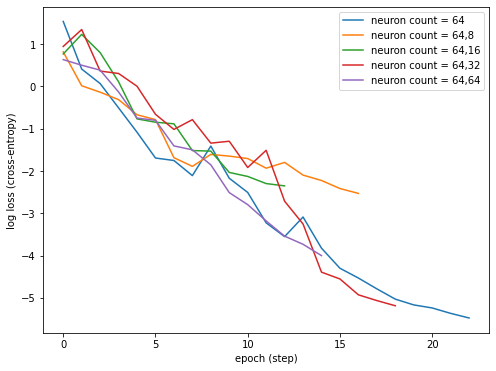

In [29]:
plt.figure(figsize = (8, 6))
plt.plot(range(len(neuron64_mlp.loss_curve_)), np.log(neuron64_mlp.loss_curve_), label = 'neuron count = 64')
plt.plot(range(len(neuron64_8_mlp.loss_curve_)), np.log(neuron64_8_mlp.loss_curve_), label = 'neuron count = 64,8')
plt.plot(range(len(neuron64_16_mlp.loss_curve_)), np.log(neuron64_16_mlp.loss_curve_), label = 'neuron count = 64,16')
plt.plot(range(len(neuron64_32_mlp.loss_curve_)), np.log(neuron64_32_mlp.loss_curve_), label = 'neuron count = 64,32')
plt.plot(range(len(neuron64_64_mlp.loss_curve_)), np.log(neuron64_64_mlp.loss_curve_), label = 'neuron count = 64,64')
plt.xlabel('epoch (step)')
plt.ylabel('log loss (cross-entropy)')
plt.legend()
plt.show()

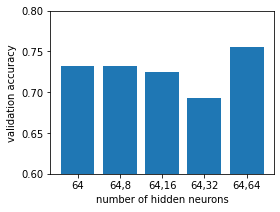

In [30]:
plt.figure(figsize = (4, 3))
plt.bar(range(5), [x.best_validation_score_ for x in [neuron64_mlp, neuron64_8_mlp, neuron64_16_mlp, neuron64_32_mlp, neuron64_64_mlp]])
plt.xticks(range(5), labels = ['64', '64,8', '64,16', '64,32', '64,64'])
plt.ylabel('validation accuracy')
plt.xlabel('number of hidden neurons')
plt.ylim([0.6, 0.8])
plt.show()

## Evaluate model performance on test set

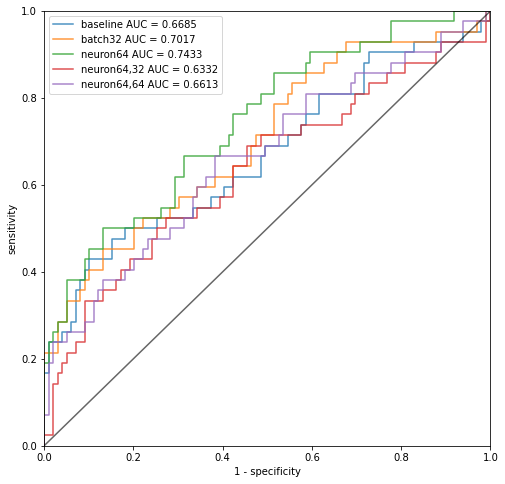

In [31]:
candidate_models = [base_mlp, batch32_adaptive_mlp, neuron64_mlp, neuron64_32_mlp, neuron64_64_mlp]
model_names = ['baseline', 'batch32', 'neuron64', 'neuron64,32', 'neuron64,64']
plt.figure(figsize = (8, 8))

for model, name in zip(candidate_models, model_names):
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label = name + ' AUC = ' + str(roc_auc_score(y_test, y_pred))[:6], alpha = 0.8)

plt.plot([0, 1], [0, 1], 'k', alpha = 0.6)
plt.axis([0, 1, 0, 1])
plt.xlabel('1 - specificity'); plt.ylabel('sensitivity')
plt.legend()
plt.show()

## View confusion matrices
### Training set

In [32]:
conf_mat = pd.DataFrame(confusion_matrix(y_train, neuron64_mlp.predict(X_train)), \
                        index = ['Known 0', 'Known 1'], columns = ['Predicted 0', 'Predicted 1'])
conf_mat.head()

,Predicted 0,Predicted 1
Known 0,284,12
Known 1,23,102


### Test set

In [33]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, neuron64_mlp.predict(X_test)), \
                        index = ['Known 0', 'Known 1'], columns = ['Predicted 0', 'Predicted 1'])
conf_mat.head()

,Predicted 0,Predicted 1
Known 0,79,20
Known 1,20,22


# Now, we will graduate from Scikit-learn and move on to Keras and Tensorflow
Install Tensorflow 2.0 with **pip install tensorflow**

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow as tf

## Define a simple one-layer model

In [35]:
def gen1L(neuron, activation):
    model = Sequential()
    model.add(Dense(units = neuron, activation = activation))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy', 'AUC'])
    
    return model

## Create a dedicated validation set (30%)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, stratify = y_train, \
                                                  shuffle = True, random_state = 3011979)

## Define callbacks
Callbacks are special instructions for the training process: **early stopping**, **reduced learning rate**, etc

In [37]:
earlystop = EarlyStopping(monitor = 'val_loss', patience = 20)
reducelr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 10)

## Train the model
Because Keras and Tensorflow do not have **random_state** parameter, we have to fix the randomness using **tf.set_random_seed(3011979)** instead

In [39]:
tf.random.set_seed(3011979)
neuron64_keras = gen1L(64, 'relu')
history = neuron64_keras.fit(X_train, y_train, batch_size = 32, epochs = 200, validation_data = (X_val, y_val), \
                             callbacks = [earlystop, reducelr])

Epoch 1/200
10/10 [==============================] - 1s 45ms/step - loss: 0.8970 - accuracy: 0.5952 - auc: 0.5233 - val_loss: 1.0348 - val_accuracy: 0.7244 - val_auc: 0.6934
Epoch 2/200
10/10 [==============================] - 0s 7ms/step - loss: 0.6007 - accuracy: 0.7925 - auc: 0.8145 - val_loss: 0.9242 - val_accuracy: 0.7323 - val_auc: 0.7064
Epoch 3/200
10/10 [==============================] - 0s 7ms/step - loss: 0.3431 - accuracy: 0.8624 - auc: 0.9046 - val_loss: 0.8951 - val_accuracy: 0.7008 - val_auc: 0.7277
Epoch 4/200
10/10 [==============================] - 0s 7ms/step - loss: 0.3060 - accuracy: 0.8920 - auc: 0.9370 - val_loss: 1.1193 - val_accuracy: 0.7008 - val_auc: 0.6728
Epoch 5/200
10/10 [==============================] - 0s 8ms/step - loss: 0.2326 - accuracy: 0.9050 - auc: 0.9627 - val_loss: 1.0018 - val_accuracy: 0.7087 - val_auc: 0.7447
Epoch 6/200
10/10 [==============================] - 0s 7ms/step - loss: 0.1530 - accuracy: 0.9601 - auc: 0.9936 - val_loss: 1.0464 - 

## We can view the ANN architecture

In [40]:
neuron64_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                178240    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 178,305
Trainable params: 178,305
Non-trainable params: 0
_________________________________________________________________


## What information is contained in history?

In [41]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc', 'lr'])


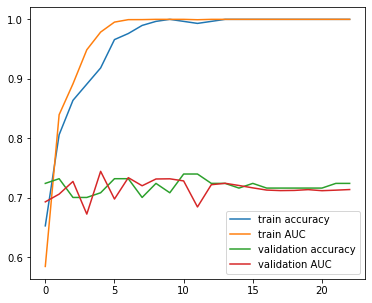

In [42]:
plt.figure(figsize = (6, 5))
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['auc'], label = 'train AUC')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history.history['val_auc'], label = 'validation AUC')
plt.legend()
plt.show()

## The curves look rough, let's slow down the learning rate
Default Adam initial learning rate is 0.001

In [43]:
def gen1L(neuron, activation, init_lr):
    model = Sequential()
    model.add(Dense(units = neuron, activation = activation))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = init_lr), metrics = ['accuracy', 'AUC'])
    
    return model

In [44]:
tf.random.set_seed(3011979)
neuron64_keras = gen1L(64, 'relu', 0.00001)
history = neuron64_keras.fit(X_train, y_train, batch_size = 32, epochs = 1000, \
                             validation_data = (X_val, y_val), \
                             verbose = 0, \
                             callbacks = [earlystop, reducelr])

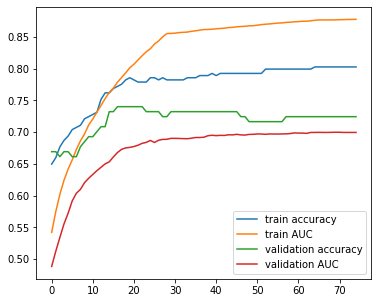

In [45]:
plt.figure(figsize = (6, 5))
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['auc'], label = 'train AUC')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history.history['val_auc'], label = 'validation AUC')
plt.legend()
plt.show()

## Looks like the training stopped too early
Let's extend the **reduce learning rate** and **early stopping** scheme

In [46]:
earlystop = EarlyStopping(monitor = 'val_loss', patience = 100)
reducelr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 50)

In [47]:
tf.random.set_seed(3011979)
neuron64_keras = gen1L(64, 'relu', 0.00001)
history = neuron64_keras.fit(X_train, y_train, batch_size = 32, epochs = 1000, \
                             validation_data = (X_val, y_val), \
                             verbose = 0, \
                             callbacks = [earlystop, reducelr])

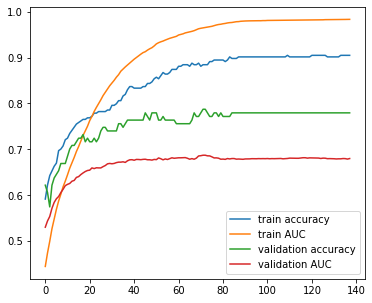

In [48]:
plt.figure(figsize = (6, 5))
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['auc'], label = 'train AUC')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history.history['val_auc'], label = 'validation AUC')
plt.legend()
plt.show()

## Let's vary the number of hidden neurons

In [50]:
histories = {}

for n in [16, 32, 64, 128, 256]:
    tf.random.set_seed(3011979)
    model = gen1L(n, 'relu', 0.00001)
    histories[n] = model.fit(X_train, y_train, batch_size = 32, epochs = 1000, \
                                      validation_data = (X_val, y_val), \
                                      verbose = 0, \
                                      callbacks = [earlystop, reducelr])

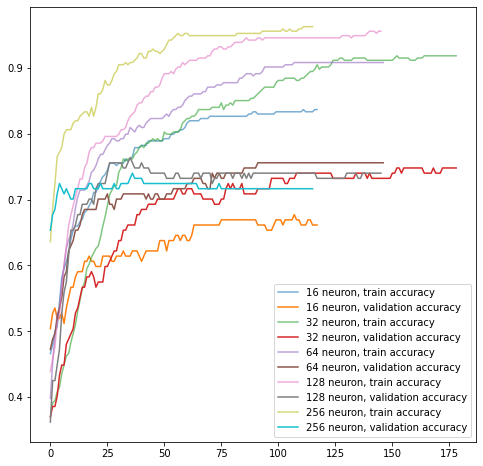

In [51]:
plt.figure(figsize = (8, 8))

for n in [16, 32, 64, 128, 256]:
    plt.plot(histories[n].history['accuracy'], label = str(n) + ' neuron, train accuracy', alpha = 0.6)
    plt.plot(histories[n].history['val_accuracy'], label = str(n) + ' neuron, validation accuracy')

plt.legend()
plt.show()

## Let's try something new - a Dropout layer

In [52]:
from tensorflow.keras.layers import Dropout

In [53]:
def gen1L_dropout(neuron, activation, init_lr, dropout_rate):
    model = Sequential()
    model.add(Dense(units = neuron, activation = activation))
    model.add(Dropout(rate = dropout_rate))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = init_lr), metrics = ['accuracy', 'AUC'])
    
    return model

## Explore various dropout rates

In [54]:
histories = {}

for r in [0.0, 0.1, 0.2, 0.3]:
    tf.random.set_seed(3011979)
    model = gen1L_dropout(128, 'relu', 0.00001, r)
    histories[r] = model.fit(X_train, y_train, batch_size = 32, epochs = 1000, \
                             validation_data = (X_val, y_val), \
                             verbose = 0, \
                             callbacks = [earlystop, reducelr])

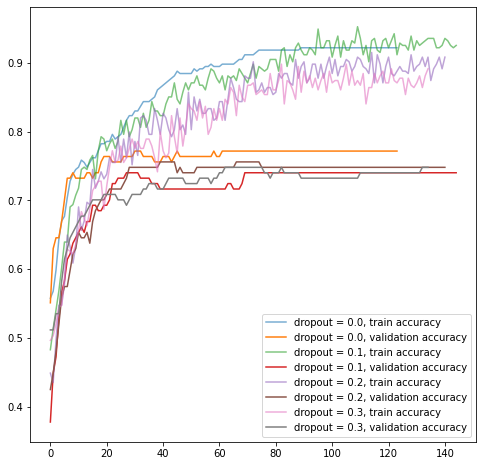

In [55]:
plt.figure(figsize = (8, 8))

for r in [0.0, 0.1, 0.2, 0.3]:
    plt.plot(histories[r].history['accuracy'], label = 'dropout = ' + str(r) + ', train accuracy', alpha = 0.6)
    plt.plot(histories[r].history['val_accuracy'], label = 'dropout = ' + str(r) + ', validation accuracy')

plt.legend()
plt.show()

## Let's train the model without early stopping or reduced learing rate
We can save the best model (based on validation) with **ModelCheckPoint** callback

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint

### Train for 10 epochs

In [58]:
tf.random.set_seed(3011979)
model = gen1L_dropout(128, 'relu', 0.00001, 0.2)
history = model.fit(X_train, y_train, batch_size = 32, epochs = 10, \
                    validation_data = (X_val, y_val), \
                    verbose = 1, \
                    callbacks = [ModelCheckpoint('./covid19_radiomics/model.ckpt', verbose = 0)])

Epoch 1/10
10/10 [==============================] - 1s 52ms/step - loss: 1.0065 - accuracy: 0.3984 - auc: 0.5088 - val_loss: 0.8202 - val_accuracy: 0.4567 - val_auc: 0.6245
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 0.9529 - accuracy: 0.4678 - auc: 0.5449 - val_loss: 0.7824 - val_accuracy: 0.4803 - val_auc: 0.6470
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
Epoch 3/10
10/10 [==============================] - 0s 7ms/step - loss: 0.8050 - accuracy: 0.4896 - auc: 0.6236 - val_loss: 0.7529 - val_accuracy: 0.5276 - val_auc: 0.6715
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 0.7753 - accuracy: 0.5126 - auc: 0.6466 - val_loss: 0.7322 - val_accuracy: 0.5591 - val_auc: 0.6829
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
Epoch 5/10
10/10 [=

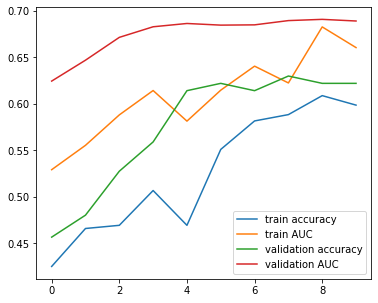

In [59]:
plt.figure(figsize = (6, 5))
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['auc'], label = 'train AUC')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history.history['val_auc'], label = 'validation AUC')
plt.legend()
plt.show()

## We can then load the trained model later on and continue training

In [60]:
new_model = tf.keras.models.load_model('./covid19_radiomics/model.ckpt')

tf.random.set_seed(3011979)
history = new_model.fit(X_train, y_train, batch_size = 32, epochs = 20, \
                        validation_data = (X_val, y_val), \
                        verbose = 1, \
                        callbacks = [ModelCheckpoint('./covid19_radiomics/model.ckpt', verbose = 0)])

Epoch 1/20
10/10 [==============================] - 1s 41ms/step - loss: 0.6001 - accuracy: 0.6633 - auc: 0.7198 - val_loss: 0.7006 - val_accuracy: 0.6299 - val_auc: 0.6867
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
Epoch 2/20
10/10 [==============================] - 0s 8ms/step - loss: 0.5982 - accuracy: 0.6667 - auc: 0.6928 - val_loss: 0.7023 - val_accuracy: 0.6299 - val_auc: 0.6842
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
Epoch 3/20
10/10 [==============================] - 0s 7ms/step - loss: 0.5616 - accuracy: 0.7177 - auc: 0.7398 - val_loss: 0.7064 - val_accuracy: 0.6299 - val_auc: 0.6854
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
Epoch 4/20
10/10 [==============================] - 0s 8ms/step - loss: 0.5470 - accuracy: 0.7279 - auc: 0.7303 - val_loss: 0.7104 - val_accuracy: 0.6457 - val_auc: 0.6804
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
Epoch 5/20
10/10 [=

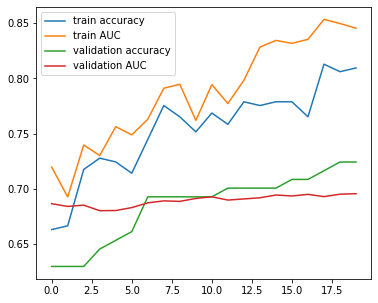

In [61]:
plt.figure(figsize = (6, 5))
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['auc'], label = 'train AUC')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history.history['val_auc'], label = 'validation AUC')
plt.legend()
plt.show()

In [ ]:
new_model2 = tf.keras.models.load_model('./covid19_radiomics/model.ckpt')

tf.random.set_seed(3011979)
history = new_model2.fit(X_train, y_train, batch_size = 32, epochs = 20, \
                        validation_data = (X_val, y_val), \
                        verbose = 1, \
                        callbacks = [ModelCheckpoint('./covid19_radiomics/model.ckpt', verbose = 0)])

In [ ]:
plt.figure(figsize = (6, 5))
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['auc'], label = 'train AUC')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history.history['val_auc'], label = 'validation AUC')
plt.legend()
plt.show()

## Our last trick of the day - TensorBoard

In [62]:
from tensorflow.keras.callbacks import TensorBoard

In [63]:
tensorboard = TensorBoard(log_dir = './covid19_radiomics/tb_logs')
checkpoint = ModelCheckpoint('./covid19_radiomics/model.ckpt', verbose = 0)

## Start a 1,000-epoch training

In [64]:
tf.random.set_seed(3011979)
model = gen1L_dropout(128, 'relu', 0.00001, 0.2)
history = model.fit(X_train, y_train, batch_size = 32, epochs = 1000, \
                    validation_data = (X_val, y_val), \
                    verbose = 0, \
                    callbacks = [checkpoint, tensorboard])

INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiom

INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiomics\model.ckpt\assets
INFO:tensorflow:Assets written to: ./covid19_radiom

KeyboardInterrupt: 

## After starting the run
1. Open a terminal (Mac OS) or command prompt (Windows)
2. Run this command: **tensorboard --logdir=PATH-TO-/covid19_radiomics/tb_logs**
3. The program should tell you to open **[http://localhost:6006/](http://localhost:6006/)** in your browser